<a href="https://colab.research.google.com/github/mdaugherity/Numerical2024/blob/main/ode/Week_10_BVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, PHYS 351, Fall 2024**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import solve_bvp

# IVP Warm-up
Let's revisit free-fall where:

$y(t)$ = height of ball at time t

$y'' = -g$

For an **IVP** problem we could have:  $y(0) = 0, y'(0) = 15$


The solver successfully reached the end of the integration interval.


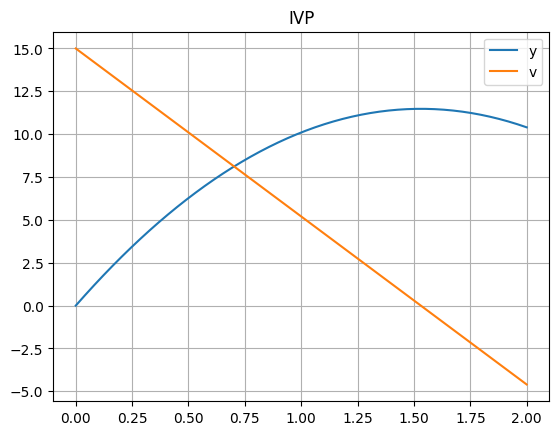

In [2]:
def yprime(t,yvec):
  y = yvec[0]
  v = yvec[1]
  return [v, -9.8]

y0 = [0, 15]  # Initial Values
TMAX = 2


ivp = solve_ivp(yprime, [0,TMAX], y0, dense_output=1)
print(ivp.message)

t = np.linspace(0,TMAX, 50)
yint = ivp.sol(t)
y = yint[0]
v = yint[1]

plt.plot(t,y,label='y')
plt.plot(t,v,label='v')
plt.legend()
plt.grid()
plt.title('IVP')
plt.show()

# SHOOTING METHOD!

Suppose instead of **initial values** $y(0), y'(0)$ we were given **boundary values** at different times.

Calling *solve_ivp* requires the initial values, so we have to use root finding to "shoot for" the initial values that give us the boundary conditions we want!

## CASE 1:  y(0)=0, y(2)=10
What initial speed does the ball have so that it is 10 m above the ground 2 seconds later?

In [3]:
# define a function to match BC
# want y(2)=10
def bc(v0):
  y0 = [0, v0]  # Initial Values
  ivp = solve_ivp(yprime, [0,TMAX], y0)
  y = ivp.y[0]
  yf = y[-1]
  v = ivp.y[1]
  vf = v[-1]
  return yf - 10

In [4]:
# Play with function to estimate root
bc(10)

-9.599999999999984

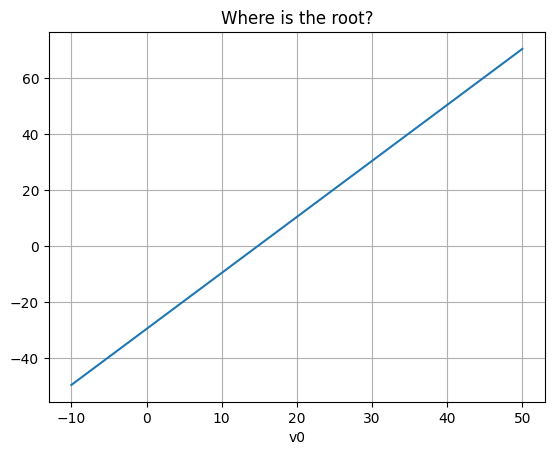

In [5]:
v0 = np.linspace(-10,50,num=4)
res = np.zeros_like(v0)
for i in range(len(v0)):
  res[i] = bc(v0[i])

plt.plot(v0, res)
plt.grid()
plt.title('Where is the root?')
plt.xlabel('v0')
plt.show()

In [6]:
from scipy.optimize import root_scalar

In [7]:
# root is a little less than 15.  Use initial guesses x0,x1
sol = root_scalar(bc, x0=15, x1 = 14.9)
print(sol)

      converged: True
           flag: converged
 function_calls: 3
     iterations: 2
           root: 14.799999999999995
         method: secant


The solver successfully reached the end of the integration interval.


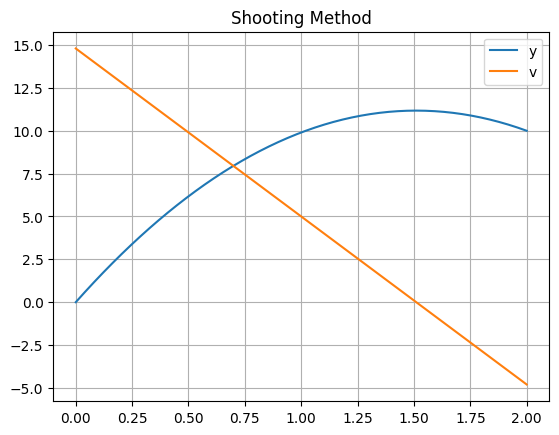

In [8]:
# Now that we know the right value for vp0, run solve_ivp one final time
v0 = sol.root
y0 = [0, v0]  # Initial Values
t = np.linspace(0,TMAX, 50)
ivp = solve_ivp(yprime, [0,TMAX], y0, t_eval = t)
print(ivp.message)

y = ivp.y[0]
v = ivp.y[1]

plt.plot(t,y,label='y')
plt.plot(t,v,label='v')
plt.legend()
plt.grid()
plt.title('Shooting Method')
plt.show()

Yes indeed, we ended up at y(2)=10

## CASE 2: y(0)=0, y'(2)=5

We'll do the problem in a single cell this time

      converged: True
           flag: converged
 function_calls: 4
     iterations: 3
           root: 24.6
         method: brentq
The solver successfully reached the end of the integration interval.


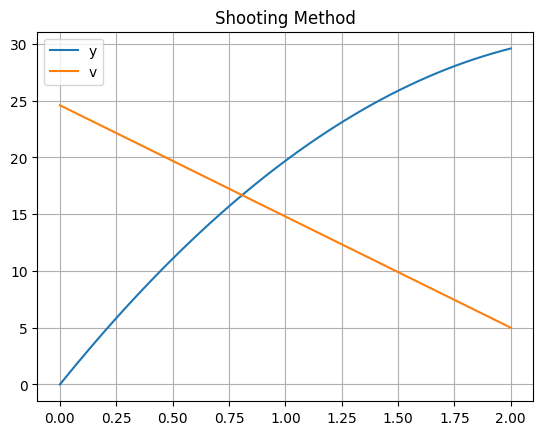

In [9]:
def bc(yp0):
  y0 = [0, yp0]  # Initial Values
  ivp = solve_ivp(yprime, [0,TMAX], y0)
  return ivp.y[1][-1] - 5

sol = root_scalar(bc, bracket=[0,100])  # using a huge bracket
print(sol)
yp0 = sol.root

y0 = [0, yp0]  # Initial Values
TMAX = 2
t = np.linspace(0,TMAX, 50)
ivp = solve_ivp(yprime, [0,TMAX], y0, t_eval = t)
print(ivp.message)

y = ivp.y[0]
v = ivp.y[1]

plt.plot(t,y,label='y')
plt.plot(t,v,label='v')
plt.grid()
plt.legend()
plt.title('Shooting Method')
plt.show()

## EXAMPLE 3
For $y'' = 4t - 4y$ and $y(0)=0$

what $y'(0)$ gives $y'(2)=0$ ?

      converged: True
           flag: converged
 function_calls: 6
     iterations: 5
           root: 2.5312521828760755
         method: brentq
The solver successfully reached the end of the integration interval.


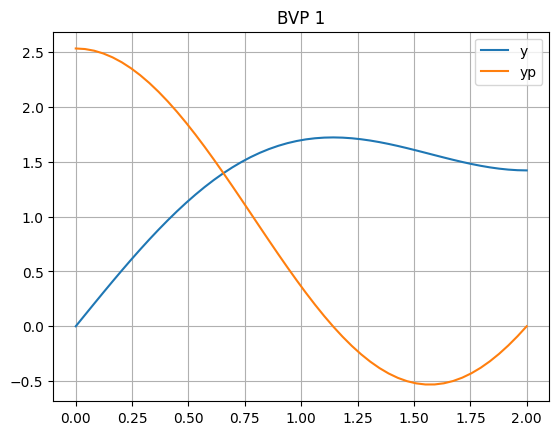

In [10]:
TMAX = 2

def f(t,y):
  y0 = y[0]
  y1 = y[1]
  return [y1, 4*t - 4*y0]

def bc(yp0):
  y0 = [0, yp0]  # Initial Values
  ivp = solve_ivp(f, [0,TMAX], y0)
  return ivp.y[1][-1] - 0

sol = root_scalar(bc, bracket=[0,3])
print(sol)
yp0 = sol.root

y0 = [0, yp0]  # Initial Values
TMAX = 2
t = np.linspace(0,TMAX, 50)
ivp = solve_ivp(f, [0,TMAX], y0, t_eval = t)
print(ivp.message)

y = ivp.y[0]
v = ivp.y[1]

plt.plot(t,y,label='y')
plt.plot(t,v, label='yp')
plt.legend()
plt.grid()
plt.title('BVP 1')
plt.show()

# Finite Difference with Relaxation

The shooting method can be difficult to generalize to bigger problems.  Let's consider another approach.

As opposed to the continuous shooting method, we will set up a discrete mesh.  
Then we can use finite difference approximations for any derivatives in our PDE.  This gives us a system of equations that must be simultaneously true for a valid solution.

While we *could* try to solve the system directly using our previous methods, one simple approach that often works is the **method of relaxation**.  We will
solve our approximated PDE for a mesh point, then starting
from some initial guess and update the points lots of times until we "relax" into a good enough solution.  

## Relaxing Free Fall
Go back to free fall BVP with $y'' = -g$ where $y(0)=0$ and $y(2)=10$.  

1) First we set up a mesh $t_i = i\Delta t$.  For laziness write $y_i = y(t_i)$.

2) Use the centered difference approximation $f''(x) \approx \frac{f(x+h)-2f(x)+f(x-h)}{h^2}$.  

3)  Plugging this into our PDE gives:  $y_{i-1}-2y_i+y_{i+1} = -\Delta t^2 g $

4) Write $y_i$ in terms of neighbors:  $y_i = \frac{1}{2} (\Delta t^2 g + y_{i-1} + y_{i+1})$.  The end points stay fixed by boundary conditions.

5) Starting from initial guess,  update each $y_i$ many times


The boundary conditions are enforced through the whole process.  If the BC is on the function value then the mesh point stays fixed.  If the BC is on the derivative then use a forward or backward approximation to calculate the end point.


## Warning about pointers
**IMPORTANT NOTE**: In numpy arrays, statements like A=B do **NOT** make a complete new copy of the data.  Instead it sets A and B pointing to the same block of memory with the data, so changing an element of A also changes B

In [11]:
A = np.zeros(5)
B = A
B[3] = 999
print("A = ",A)
print("B = ",B)

A =  [  0.   0.   0. 999.   0.]
B =  [  0.   0.   0. 999.   0.]


To prevent this from happening you can use the copy() function

In [12]:
A = np.zeros(5)
B = A.copy()   # make a new copy
B[3] = 999
print("A = ",A)
print("B = ",B)

A =  [0. 0. 0. 0. 0.]
B =  [  0.   0.   0. 999.   0.]


## Manual Relaxation Steps
Do some manual updates for a few steps so we can watch it converge



In [13]:
# Define mesh and initial guess
NUMT = 10
T0 = 0  # initial time
TF = 2  # final time
t = np.linspace(T0, TF, NUMT)

y = np.zeros(NUMT)
Y0 = 0  # initial height
YF = 10 # final height
y0 = np.linspace(Y0, YF, NUMT)

In [14]:
# One update
dt = t[1]-t[0]
g = 9.8
y=y0.copy()
y[0] = Y0
y[-1] = YF
for i in range(1, NUMT-1):
  y[i] = 0.5*(dt**2*g + y[i+1]+y[i-1])

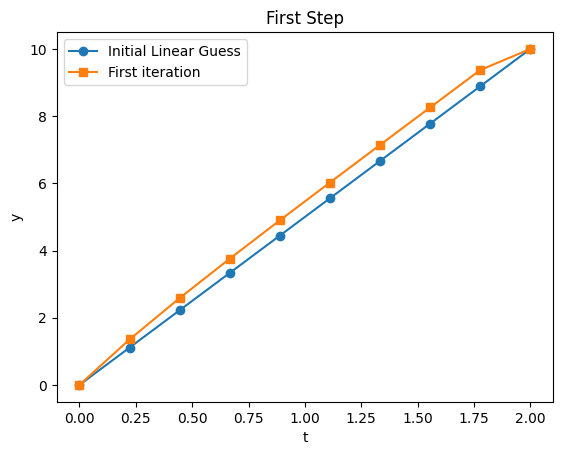

In [15]:
plt.plot(t, y0,'o-', label='Initial Linear Guess')
plt.plot(t, y, 's-',label='First iteration')
plt.legend()
plt.title('First Step')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

In [16]:
def update(y):
  y[0] = Y0
  y[-1] = YF
  for i in range(1, NUMT-1):
    y[i] = 0.5*(dt**2*g + y[i+1]+y[i-1])
  return

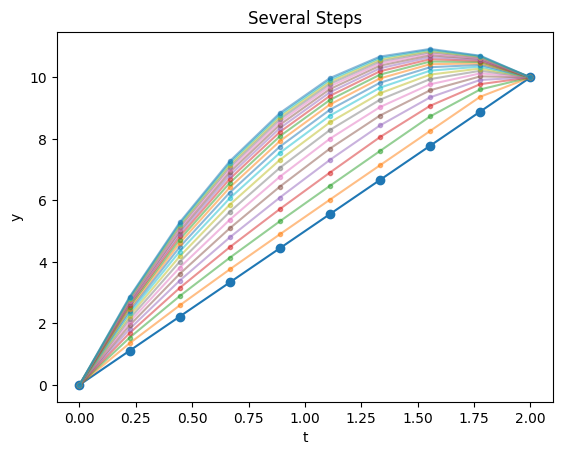

In [17]:
# Reset y and do several steps
plt.plot(t,y0,'o-')
y = y0.copy()
for i in range(20):
  update(y)
  #plt.plot(t,y,'.-')
  plt.plot(t,y,'.-', alpha=0.5)

plt.title('Several Steps')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

## Automatic Relaxation
How many steps do we need?  The typical approach is to define a tolerance and stop when it is larger than the biggest change between iterations.

Here's the whole thing together.



In [18]:
# Define mesh and initial guess
NUMT = 10
T0 = 0  # initial time
TF = 2  # final time
t = np.linspace(T0, TF, NUMT)

Y0 = 0  # initial height
YF = 10 # final height
y0 = np.linspace(Y0, YF, NUMT)
y = y0.copy()  #initialize y

STEPS=0 # counting number of steps
done=0 # flag
while not done:
  yold = y.copy()
  y[0] = Y0
  y[-1] = YF
  for i in range(1, NUMT-1):
    y[i] = 0.5*(y[i+1]+y[i-1]+dt**2*g)

  r = y-yold
  diff = np.abs(r.max())
  #print(diff)
  if diff<1e-3:
    done = 1
  STEPS +=1

print(f'Ended with {STEPS} steps and final change {diff}')

Ended with 53 steps and final change 0.000967680561560158


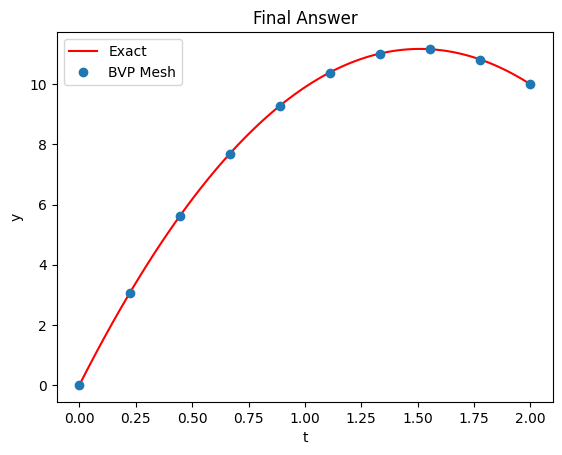

In [20]:
t_exact = np.linspace(T0, TF, 100)
v0 = 14.8
y_exact = v0*t_exact - 0.5*g * t_exact**2

plt.plot(t_exact,y_exact,'r-',label='Exact')
plt.plot(t,y,'o',label='BVP Mesh')
plt.title('Final Answer')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()